# SMOTE with ML implementation.
**OPIM 5512: Data Science Using Python - University of Connecticut**

-----------------------------------------------
The Brownlee article has a few other good SMOTE variants related to 'selective sampling' - let's use a real dataset instead of the dummy data and see how we would integrate it into a ML modeling framework.

The main idea here is that we are going to make synthetic samples where we have 'hard to classify' or 'sparse' datapoints - this way we have targeted SMOTE where we really need it.

# Import modules and read data

In [ ]:
# this is to get rid of some annoying future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# the usual suspects...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for our nearest neighbor algorithm
from sklearn.neighbors import NearestNeighbors
# random number generator
import random
# counter
from collections import Counter


In [ ]:
# https://drive.google.com/file/d/1zhcJY3KXP6dcsaTla0X7EmTsVSx1jTrV/view?usp=sharing
!gdown 1zhcJY3KXP6dcsaTla0X7EmTsVSx1jTrV

Downloading...
From: https://drive.google.com/uc?id=1zhcJY3KXP6dcsaTla0X7EmTsVSx1jTrV
To: /content/housing_simple_DTR.csv
100% 12.4k/12.4k [00:00<00:00, 26.4MB/s]


In [ ]:
# mount your drive on the left
df = pd.read_csv('housing_simple_DTR.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489 entries, 0 to 488
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   RM       489 non-null    float64
 1   LSTAT    489 non-null    float64
 2   PTRATIO  489 non-null    float64
 3   MEDV     489 non-null    float64
dtypes: float64(4)
memory usage: 15.4 KB


,RM,LSTAT,PTRATIO,MEDV
0,6.575,4.98,15.3,504000.0
1,6.421,9.14,17.8,453600.0
2,7.185,4.03,17.8,728700.0
3,6.998,2.94,18.7,701400.0
4,7.147,5.33,18.7,760200.0


I want to see everything in 2D space, so I'm going to drop `PTRATIO`.

In [ ]:
df.drop('PTRATIO', axis=1, inplace=True)
df.head()

,RM,LSTAT,MEDV
0,6.575,4.98,504000.0
1,6.421,9.14,453600.0
2,7.185,4.03,728700.0
3,6.998,2.94,701400.0
4,7.147,5.33,760200.0


Because we are using SMOTE and it's for regression, let's recode the target variable to be 0/1. For a twist, let's make it if a house is greater than 400000.

In [ ]:
# recoding in place - if greater than the median, it gets a 1, otherwise a 0
df['MEDV'] = np.where(df['MEDV'] > 400000, 1, 0)
df.head() # voila!

,RM,LSTAT,MEDV
0,6.575,4.98,1
1,6.421,9.14,1
2,7.185,4.03,1
3,6.998,2.94,1
4,7.147,5.33,1


In [ ]:
from collections import Counter
Counter(df['MEDV'])

Counter({1: 314, 0: 175})

In [ ]:
# in this case, the 1s are the majority class
# and the 0s are the minority class
# our goal is to beef up the minority class with synthetic samples of the minority class

# Split into X and y

In [ ]:
X = df.drop('MEDV', axis=1)
X # these are our NUMERIC features

,RM,LSTAT
0,6.575,4.98
1,6.421,9.14
2,7.185,4.03
3,6.998,2.94
4,7.147,5.33
...,...,...
484,6.593,9.67
485,6.120,9.08
486,6.976,5.64
487,6.794,6.48


Get the distributions...

In [ ]:
X.describe()

,RM,LSTAT
count,489.000000,489.000000
mean,6.240288,12.939632
std,0.643650,7.081990
min,3.561000,1.980000
25%,5.880000,7.370000
50%,6.185000,11.690000
75%,6.575000,17.120000
max,8.398000,37.970000


In [ ]:
y = df['MEDV']
y

0      1
1      1
2      1
3      1
4      1
      ..
484    1
485    1
486    1
487    1
488    0
Name: MEDV, Length: 489, dtype: int64

# Visualize the Raw Data (before SMOTE)

In [ ]:
X = np.array(X)
y = np.array(y)

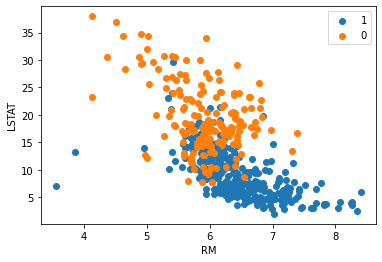

In [ ]:
counter = Counter(y)

# scatter plot of examples by class label
for label, _ in counter.items():
 row_ix = np.where(y == label)[0]
 plt.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
plt.ylabel('LSTAT')
plt.xlabel('RM')
plt.legend()
plt.show()

Isn't cool to see the real data instead of a mock-up? It will be fun to see how this undergoes a transformation!

# Split into Train and Test
YES! You should split into train and test partitions BEFORE doing SMOTE - this way you have some original data on the side for testing. You can train on SMOTE, but you should not test on it (it's fake data, afterall).

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape) # looks good!

(391, 2) (98, 2)
(391,) (98,)


Let's look at the class distribution in `y_train` and `y_test`.

In [ ]:
# train
Counter(y_train)

Counter({1: 255, 0: 136})

In [ ]:
# test
Counter(y_test)

Counter({1: 59, 0: 39})

# Apply vanilla SMOTE to train partition
Since we only have numeric features, let's apply SMOTE. This will increase the 0s from 136 to 255.

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SVMSMOTE

# transform the dataset
oversample = SMOTE(k_neighbors=9)

# if you want to try a fancy SMOTE - try this! it's an SVM instead of KNN
# oversample = SVMSMOTE()

X_res, y_res = oversample.fit_resample(X_train, y_train) # notice the use of train NOT test or raw X, y
# summarize the new class distribution
counter = Counter(y_res)
print(counter)

Counter({1: 255, 0: 255})


Perfect! Now we have matching numbers of classes. Let's see what this looks like on our real-world dataset.

# Visualize vanilla SMOTE on train partition

If you look closely, you will see some differences!

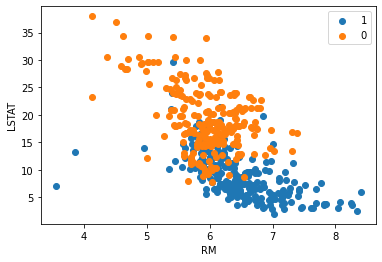

In [ ]:
# scatter plot of examples by class label
for label, _ in counter.items():
 row_ix = np.where(y_res == label)[0]
 plt.scatter(X_res[row_ix, 0], X_res[row_ix, 1], label=str(label))
plt.ylabel('LSTAT')
plt.xlabel('RM')
plt.legend()
plt.show()

You can see along the top clearly that a few points have been added.

# Fit a ML models on X_train vs. X_res
Fit a model on your resampled data vs. your original X_train and compare the results.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
DTC = DecisionTreeClassifier(min_samples_split=10)

Note the class imbalance in the train partition - this model will learn different patterns than the SMOTE model!

In [ ]:
# original data
DTC.fit(X_train, y_train)
train_preds = DTC.predict(X_train)
test_preds = DTC.predict(X_test)

print('Train results: \n')
print(classification_report(y_train, train_preds))
print('Test results: \n')
print(classification_report(y_test, test_preds))

Train results: 

              precision    recall  f1-score   support

           0       0.95      0.92      0.94       136
           1       0.96      0.98      0.97       255

    accuracy                           0.96       391
   macro avg       0.96      0.95      0.95       391
weighted avg       0.96      0.96      0.96       391

Test results: 

              precision    recall  f1-score   support

           0       0.82      0.69      0.75        39
           1       0.82      0.90      0.85        59

    accuracy                           0.82        98
   macro avg       0.82      0.80      0.80        98
weighted avg       0.82      0.82      0.81        98



In [ ]:
# SMOTE data
DTC.fit(X_res, y_res)
train_preds = DTC.predict(X_res)
test_preds = DTC.predict(X_test)
print('Train results: \n')
print(classification_report(y_res, train_preds))
print('Test results: \n')
print(classification_report(y_test, test_preds))

Train results: 

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       255
           1       0.95      0.93      0.94       255

    accuracy                           0.94       510
   macro avg       0.94      0.94      0.94       510
weighted avg       0.94      0.94      0.94       510

Test results: 

              precision    recall  f1-score   support

           0       0.81      0.77      0.79        39
           1       0.85      0.88      0.87        59

    accuracy                           0.84        98
   macro avg       0.83      0.83      0.83        98
weighted avg       0.84      0.84      0.84        98



It seems that the SMOTE model has the same weighted accuracy for the test partition, there are different trends for precision and recall. Depending on your biz problem, one may be more appropriate than the other.

# [optional] Looking for more? How about SMOTE for regression!
This is optional content, but you may wish to try extending what you know about classification problems to REGRESSION problems. Feel free to read on your own! Uses `smogn` instead of `imblearn`.
* https://pypi.org/project/smogn/
* Beginner example: https://github.com/nickkunz/smogn/blob/master/examples/smogn_example_1_beg.ipynb
* Intermediate example: https://github.com/nickkunz/smogn/blob/master/examples/smogn_example_2_int.ipynb
* Advanced example: https://github.com/nickkunz/smogn/blob/master/examples/smogn_example_3_adv.ipynb

Pay attention to the density plots... they should look less skewed after running SMOTE for regression!